In [1]:
from __future__ import division
import sys
import argparse
import numpy as np
import pretty_midi
import librosa

(128, 1589)


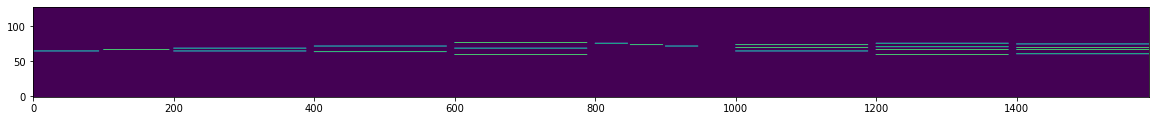

In [2]:
# Replace the sample.mid in the next line with your midi file name.

f = "sample.mid"
midi_data = pretty_midi.PrettyMIDI(f)
fs = 200 #midi sampling frequency
piano_matrix = midi_data.get_piano_roll(fs=200)

import numpy as np
print(np.shape(piano_matrix))
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
#plt.imshow(piano_matrix[:,:1000], origin="lower")
plt.imshow(piano_matrix, origin="lower")

In [3]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.

    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.

    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.

    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


In [4]:
def cqt_to_piano_roll(cqt, min_midi, max_midi, threshold):
    '''Convert a CQT spectrogram into a piano roll representation by
     thresholding scaled magnitudes.

    Parameters
    ----------
    cqt : np.ndarray, shape=(max_midi-min_midi,frames), dtype=complex64
        CQT spectrogram of audio.
    min_midi : int
        Minimum MIDI note to transcribe.
    max_midi : int
        Maximum MIDI note to transcribe.
    threshold : int
        Threshold value to activate note on event, 0-127

    Returns
    -------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll representation on audio.

    '''
    piano_roll = np.abs(cqt)
    piano_roll = np.digitize(piano_roll,
                             np.linspace(piano_roll.min(),
                                         piano_roll.max(),
                                         127))
    piano_roll[piano_roll < threshold] = 0
    piano_roll = np.pad(piano_roll,
                        [(min_midi, 128 - max_midi), (0, 0)],
                        'constant')
    return piano_roll


Try using different timbres. Uncomment the lines with samples from different instruments to see the results. 

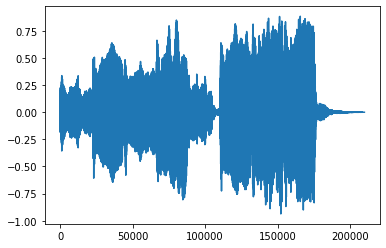

In [20]:
# Replace sample.wav with your sound file
#y, sr = librosa.load("sample-sin.wav")
y, sr = librosa.load("sample-bottle.wav")
#y, sr = librosa.load("sample-piano.wav")

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y)

In [21]:
import IPython.display as ipd
ipd.Audio(data=y, rate=sr)

In [22]:
def note2Hz(note):
    a = 440 #frequency of A (coomon value is 440Hz)
    return a * (2 ** ((note - 69) / 12)) 

Try changing the filter_scale parameter to get better frequency resolution but worse time resolution.

https://en.wikipedia.org/wiki/Constant-Q_transform

https://librosa.org/doc/latest/generated/librosa.cqt.html

In [23]:
# Set a threshold 0-127 to find the notes 
min_midi = 24 # Minimum MIDI note to transcribe
max_midi = 110 # Maximum MIDI note to transcribe
filter_scale = 4 #try 2 for sinusoid or bottle, 4 for piano
cqt = librosa.cqt(y, sr=sr, fmin=note2Hz(min_midi), tuning = 0.0, filter_scale = filter_scale, n_bins=max_midi - min_midi+1)

To undersdtand CQT frequency decomposition, we print below the freqeuncies of the filters and then compute their corresponding note numbers. 
You can see that the spacing of the CQT corresponds to notes on the keyboard. 
So the reason for choosing CQT is to match the frequency bins of the signal analysis to the piano-roll.

In [24]:
f_cqt = librosa.cqt_frequencies(n_bins=max_midi - min_midi+1, fmin=note2Hz(min_midi), bins_per_octave=12, tuning=0.0)
print(f_cqt)

[  32.70319566   34.64782887   36.70809599   38.89087297   41.20344461
   43.65352893   46.24930284   48.9994295    51.9130872    55.
   58.27047019   61.73541266   65.40639133   69.29565774   73.41619198
   77.78174593   82.40688923   87.30705786   92.49860568   97.998859
  103.82617439  110.          116.54094038  123.47082531  130.81278265
  138.59131549  146.83238396  155.56349186  164.81377846  174.61411572
  184.99721136  195.99771799  207.65234879  220.          233.08188076
  246.94165063  261.6255653   277.18263098  293.66476792  311.12698372
  329.62755691  349.22823143  369.99442271  391.99543598  415.30469758
  440.          466.16376152  493.88330126  523.2511306   554.36526195
  587.32953583  622.25396744  659.25511383  698.45646287  739.98884542
  783.99087196  830.60939516  880.          932.32752304  987.76660251
 1046.5022612  1108.73052391 1174.65907167 1244.50793489 1318.51022765
 1396.91292573 1479.97769085 1567.98174393 1661.21879032 1760.
 1864.65504607 1975.5332

In [25]:
def Hz2Note(f):
    a = 440 #frequency of A note (coomon value is 440Hz)
    return np.round(12*np.log2(f/a) + 69) 

In [26]:
Hz2Note(f_cqt)

array([ 24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 108., 109., 110.])

To see better the CQT values it helps to use log scaling of the amplitudes. We add small value to the log to aviod zeros

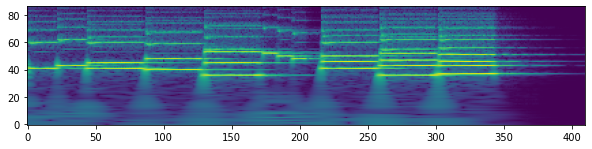

In [27]:
plt.figure(figsize=(10,20))
plt.imshow(np.log(np.abs(cqt)+0.001),origin = "lower")

In [28]:
fmin=note2Hz(min_midi)
print(fmin)

32.70319566257483


Change the treshold manually to see how it affects the piano roll. 
Challenge: Is there a way to set the threshold adaptively to the signal? 

Note: it might also change with different CQT parameters, such as filter_scale

In [29]:
threshold = 40 # Threshold to activate note on event, 0-127
#for sinusoid try 40, for bottle try 25, piano 40 with filter_scale = 4
pr = cqt_to_piano_roll(cqt, min_midi, max_midi, threshold)

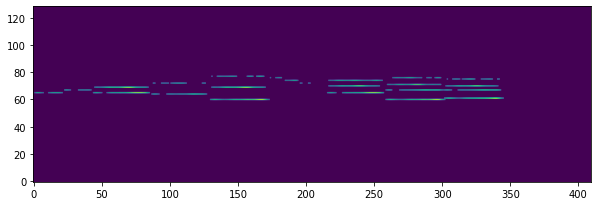

In [30]:
plt.figure(figsize=(10,20))
plt.imshow(pr,origin="lower")

In [31]:
# get audio time
audio_time = len(y) / sr
# get sampling frequency of cqt spectrogram
fs = pr.shape[1]/audio_time
pm = piano_roll_to_pretty_midi(pr, fs=fs,program=0)
pm.write("sample_to_midi.mid")

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): image not found 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/gk/sy2z39qs1js8sj30zc1yzx040000gp/T/music21/tmpl3i9utyp.xml>...
Error at line 429 col 14: rounding up measure duration 25/24 to 67/64
Error at line 623 col 14: rounding up measure duration 25/24 to 67/64
tuplet 0x7fa567017460 not stopped at end of measure, tick 97/48 duration 1/48 missing 1/96
add missing 1/96 to previous tuplet
too many voices (staff=1 voice='4' -> s=-1 v=-1)
	to </var/folders/gk/sy2z39qs1js8sj30zc1yzx040000gp/T/music21/tmpl3i9utyp.png>
... success!


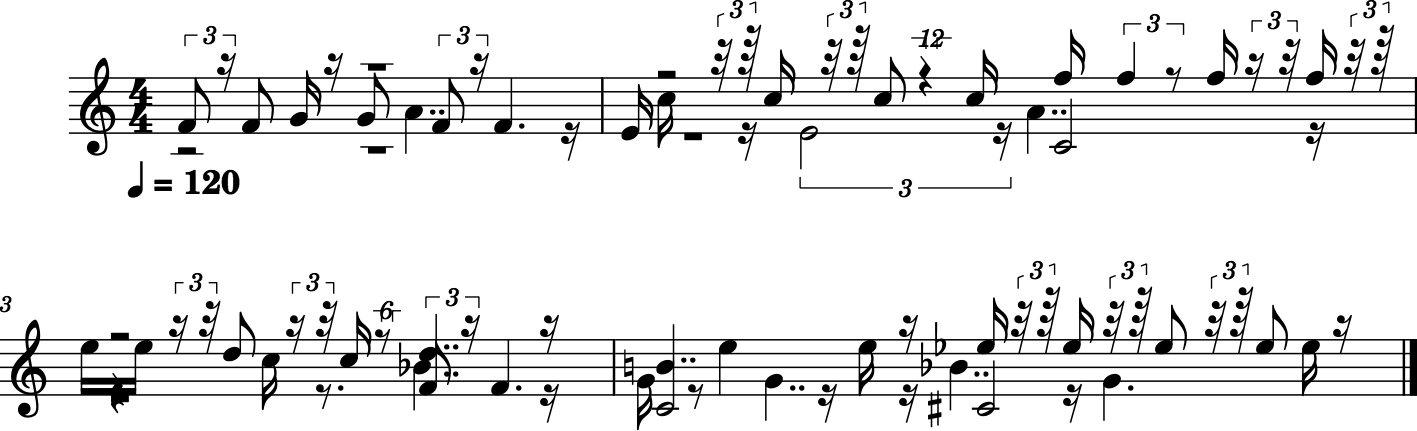

In [32]:
import music21 as mus
score1 = mus.converter.parse("sample_to_midi.mid")
score1.show()

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): image not found 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/gk/sy2z39qs1js8sj30zc1yzx040000gp/T/music21/tmpv841smjc.xml>...
	to </var/folders/gk/sy2z39qs1js8sj30zc1yzx040000gp/T/music21/tmpv841smjc.png>
... success!


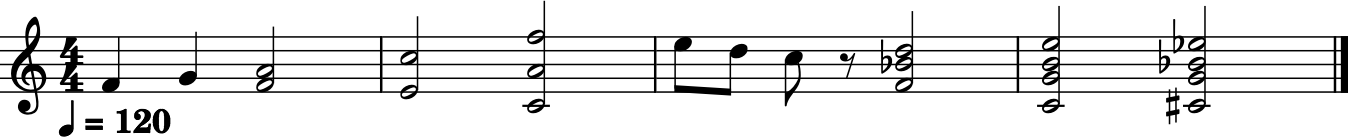

In [33]:
score = mus.converter.parse("sample.mid")
score.show()